## En este Notebook se busca seguir el mismo framework realizado con Santiago, pero en este caso con Madrid para testear similitud

In [8]:
import json
from pathlib import Path
import requests

from math import radians, cos, sin, asin, sqrt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import networkx as nx

from shapely.geometry import shape, Point, LineString
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import contextily as cx

In [2]:
min_lon, min_lat = -3.79, 40.36
max_lon, max_lat = -3.59, 40.50

overpass_query = f"""
[out:json][timeout:180][bbox:{min_lat},{min_lon},{max_lat},{max_lon}];
(
  node["amenity"="school"];
  node["amenity"="university"];
  node["amenity"="college"];
  node["amenity"="kindergarten"];
  node["shop"];
  node["amenity"="restaurant"];
  node["amenity"="cafe"];
  node["amenity"="bank"];
  node["amenity"="pharmacy"];
  node["amenity"="hospital"];
  node["amenity"="clinic"];
  node["amenity"="doctors"];
  node["public_transport"="stop_position"];
  node["highway"="bus_stop"];
  node["leisure"="park"];
  node["leisure"="playground"];
  node["amenity"="police"];
  node["amenity"="fire_station"];
  node["amenity"="library"];
);

out body;
"""

In [3]:
# Función para obtener datos de Overpass API
def get_overpass_data(query):
    """
    Consulta la API de Overpass y retorna los datos en formato JSON
    """
    overpass_url = "http://overpass-api.de/api/interpreter"
    response = requests.post(overpass_url, data={'data': query})
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error en la consulta: {response.status_code}")

# Función para clasificar el tipo de nodo
def classify_node(tags):
    """
    Clasifica un nodo según sus tags de OSM
    """
    if 'amenity' in tags:
        amenity = tags['amenity']
        if amenity in ['school', 'university', 'college', 'kindergarten']:
            return 'educacion'
        elif amenity in ['restaurant', 'cafe']:
            return 'gastronomia'
        elif amenity in ['hospital', 'clinic', 'doctors']:
            return 'salud'
        elif amenity in ['bank', 'pharmacy']:
            return 'servicios'
        elif amenity in ['police', 'fire_station']:
            return 'seguridad'
        elif amenity == 'library':
            return 'cultura'
    
    if 'shop' in tags:
        return 'comercio'
    
    if 'public_transport' in tags or 'highway' in tags:
        return 'transporte'
    
    if 'leisure' in tags:
        return 'recreacion'
    
    return 'otro'

In [4]:
print("Obteniendo datos de Overpass API...")
data = get_overpass_data(overpass_query)

# Procesar los nodos
nodes_data = []
for element in data['elements']:
    if element['type'] == 'node':
        node_info = {
            'id': element['id'],
            'lat': element['lat'],
            'lon': element['lon'],
            'tipo': classify_node(element.get('tags', {})),
            'nombre': element.get('tags', {}).get('name', 'Sin nombre'),
            'tags': element.get('tags', {})
        }
        nodes_data.append(node_info)

print(f"Total de nodos obtenidos: {len(nodes_data)}")

# Crear DataFrame
df_nodes = pd.DataFrame(nodes_data)
g_nodes = gpd.GeoDataFrame(df_nodes.copy(), geometry=gpd.points_from_xy(df_nodes["lon"], df_nodes["lat"]), crs="EPSG:4326")
g_nodes_m = g_nodes.to_crs("EPSG:32719")
coords = np.c_[g_nodes_m.geometry.x.values, g_nodes_m.geometry.y.values]
tree = cKDTree(coords)

print("\nDistribución de tipos de nodos:")
print(df_nodes['tipo'].value_counts())
print("\nCalculando conexiones (esto puede tomar un tiempo)...")


MAX_DISTANCE = 200  # metros
neighbors = tree.query_ball_tree(tree, r=MAX_DISTANCE)

edges_list = []
for i, neigh_list in enumerate(neighbors):
    for j in neigh_list:
        if i < j:
            id_i = g_nodes.iloc[i]["id"]
            id_j = g_nodes.iloc[j]["id"]
            edges_list.append((id_i, id_j))

# Construir grafo
G = nx.Graph()
for _, node in df_nodes.iterrows():
    G.add_node(node['id'], 
               lat=node['lat'], 
               lon=node['lon'], 
               tipo=node['tipo'],
               nombre=node['nombre'])
G.add_edges_from(edges_list)

# 4. Construir edges sin doble for N²
edges = []
for i, neigh_list in enumerate(neighbors):
    for j in neigh_list:
        if i < j:
            edges.append((g_nodes.iloc[i]["id"], g_nodes.iloc[j]["id"]))

Obteniendo datos de Overpass API...
Total de nodos obtenidos: 32273

Distribución de tipos de nodos:
tipo
comercio       12338
transporte      9930
gastronomia     5583
servicios       2730
educacion        743
recreacion       529
salud            349
cultura           53
seguridad         18
Name: count, dtype: int64

Calculando conexiones (esto puede tomar un tiempo)...


In [10]:
# Estadísticas del grafo
print("\n=== ESTADÍSTICAS DEL GRAFO ===")
print(f"Número de nodos: {G.number_of_nodes()}")
print(f"Número de aristas: {G.number_of_edges()}")
print(f"Densidad del grafo: {nx.density(G):.6f}")
print(f"¿Es conexo?: {nx.is_connected(G)}")
if not nx.is_connected(G):
    componentes = list(nx.connected_components(G))
    print(f"Número de componentes conexas: {len(componentes)}")
    print(f"Tamaño de la componente más grande: {len(max(componentes, key=len))}")

# Guardar datos
print("\nGuardando datos...")
df_nodes.to_csv('../data/nodos_madrid.csv', index=False)
nx.write_gexf(G, '../data/grafo_OSM/grafo_madrid.gexf')
print("Datos guardados: 'nodos_madrid.csv' y 'grafo_madrid.gexf'")


=== ESTADÍSTICAS DEL GRAFO ===
Número de nodos: 32273
Número de aristas: 641009
Densidad del grafo: 0.001231
¿Es conexo?: False
Número de componentes conexas: 691
Tamaño de la componente más grande: 22631

Guardando datos...
Datos guardados: 'nodos_madrid.csv' y 'grafo_madrid.gexf'



Generando visualización...
Grafo guardado como 'grafo_madrid_urbano.png'


<Figure size 640x480 with 0 Axes>

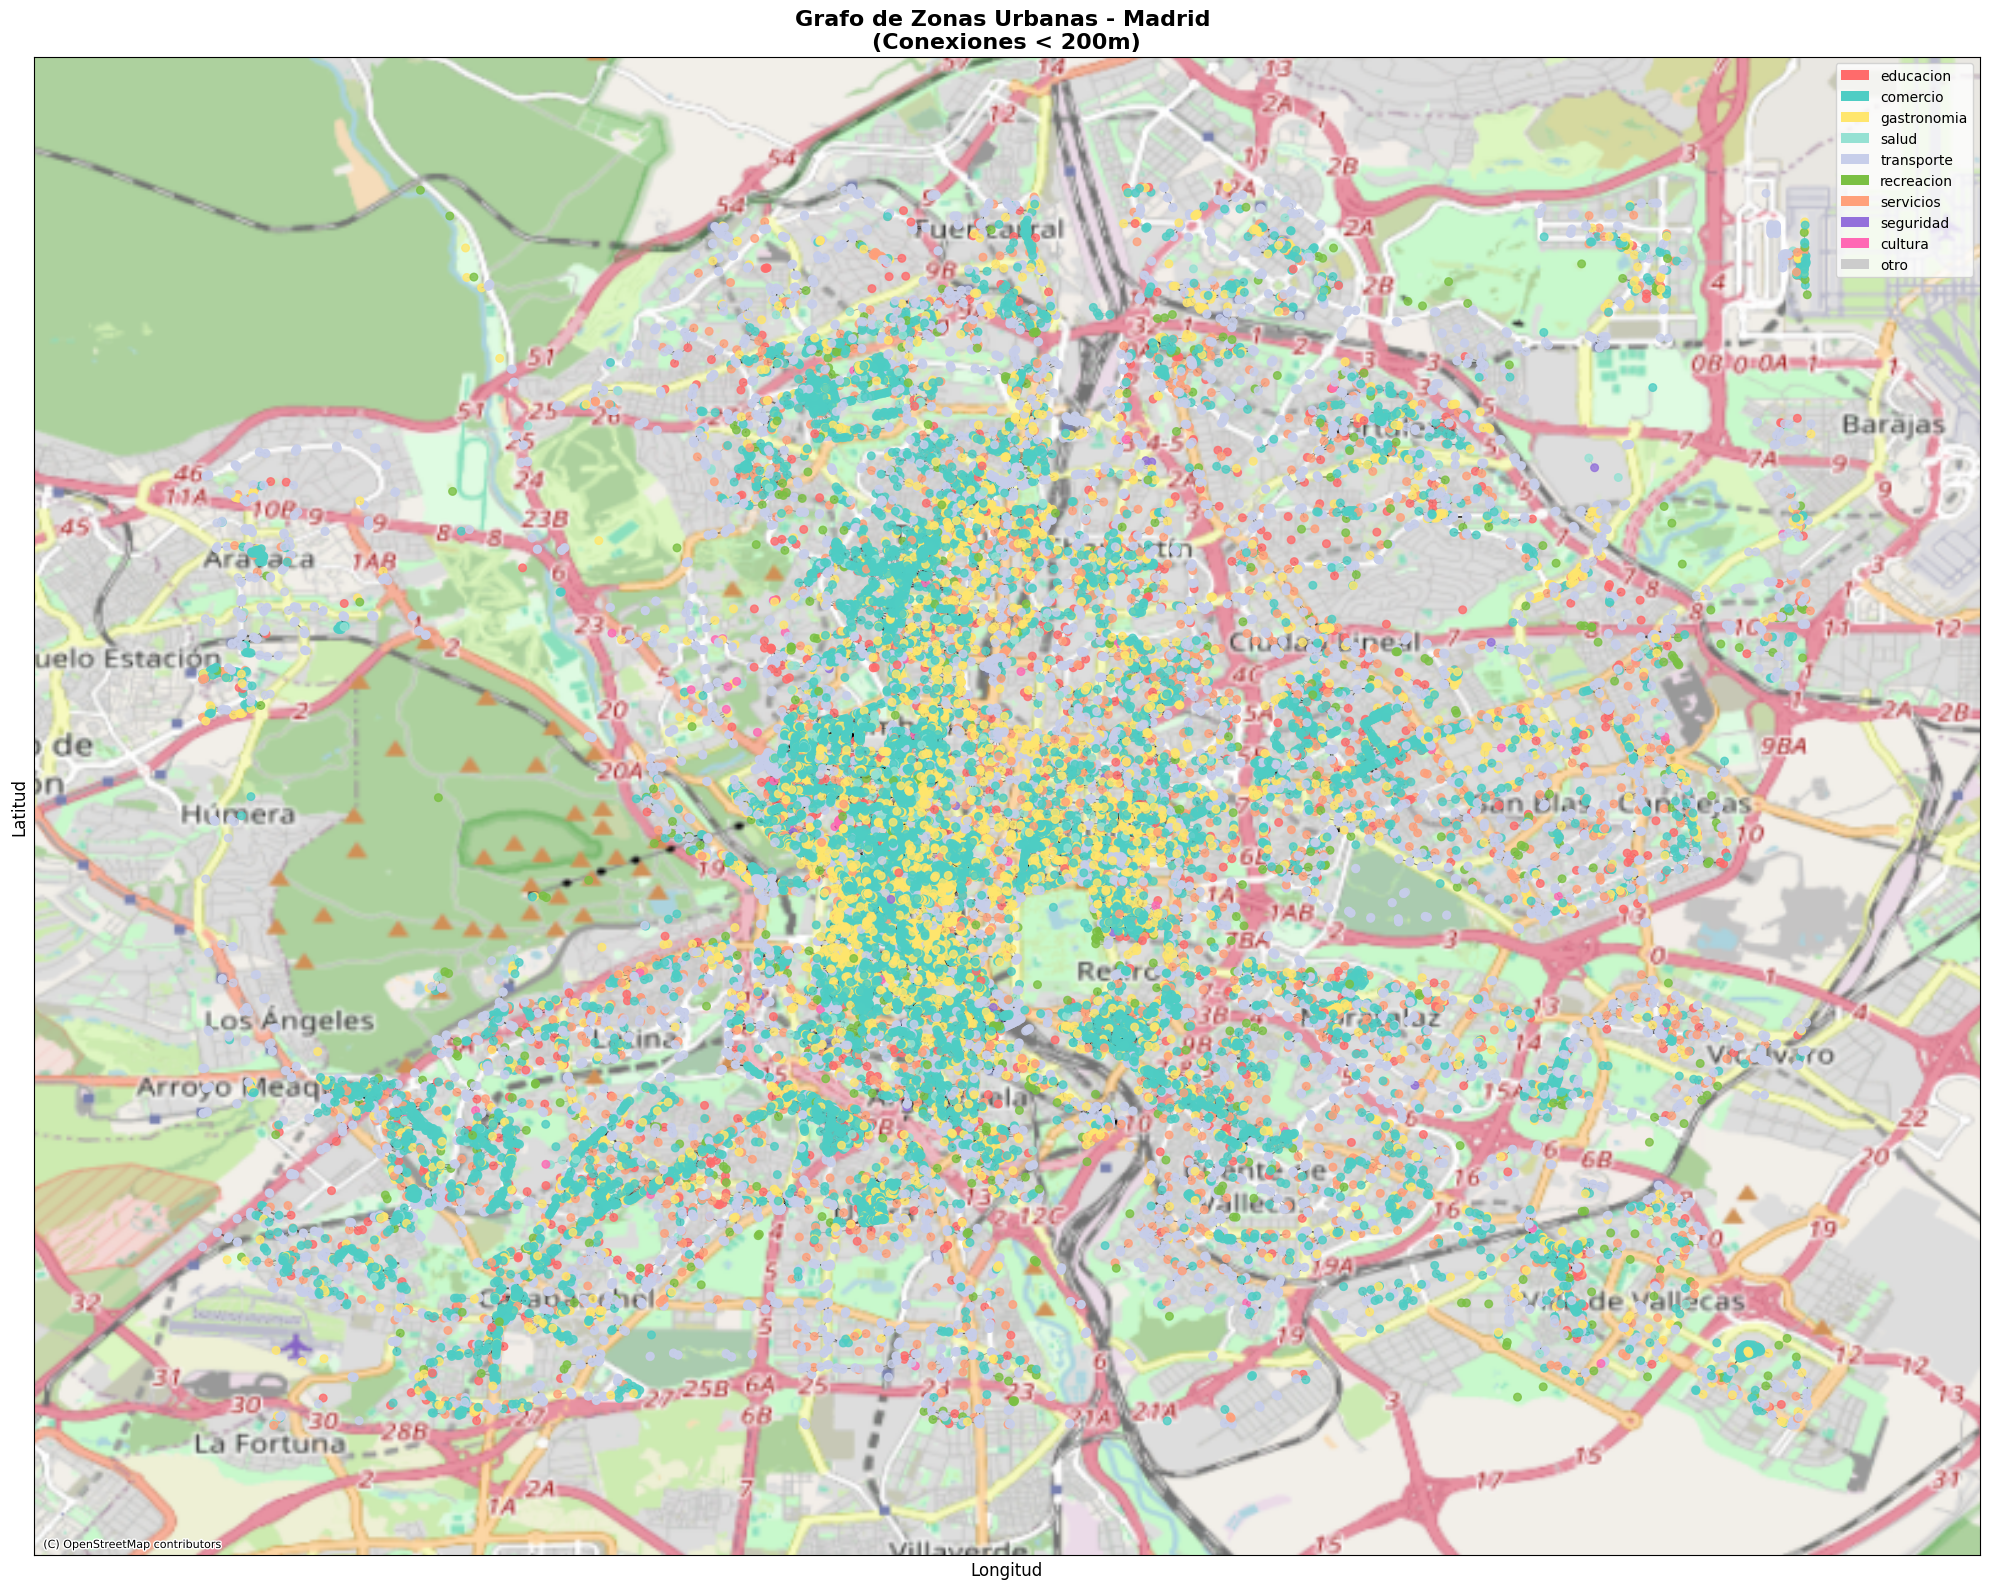

In [9]:
# Visualizar el grafo
print("\nGenerando visualización...")

# Colores para cada tipo de nodo
color_map = {
    'educacion': '#FF6B6B',
    'comercio': '#4ECDC4',
    'gastronomia': '#FFE66D',
    'salud': '#95E1D3',
    'transporte': '#C7CEEA',
    'recreacion': '#7BC043',
    'servicios': '#FFA07A',
    'seguridad': '#9370DB',
    'cultura': '#FF69B4',
    'otro': '#CCCCCC'
}

node_colors = [color_map.get(G.nodes[node]['tipo'], '#CCCCCC') for node in G.nodes()]

# Usar posiciones geográficas reales
pos = {node: (G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes()}
plt.savefig('../figs/grafo_santiago_urbano.png', dpi=300, bbox_inches='tight')
print("Grafo guardado como 'grafo_madrid_urbano.png'")


plt.figure(figsize=(20, 16))
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

# Crear leyenda
legend_elements = [Patch(facecolor=color, label=tipo) 
                   for tipo, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.title(f'Grafo de Zonas Urbanas - Madrid \n(Conexiones < {MAX_DISTANCE}m)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.tight_layout()
ax = plt.gca()
cx.add_basemap(ax, crs=G.graph['crs'] if 'crs' in G.graph else 'EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik, zoom=12)

plt.show()